# Smoke/No-Smoke Classification - Draft
* MXNET/Gluon https://mxnet.apache.org/
* ResNet Model

### ResNet Architecture
* 50-layer
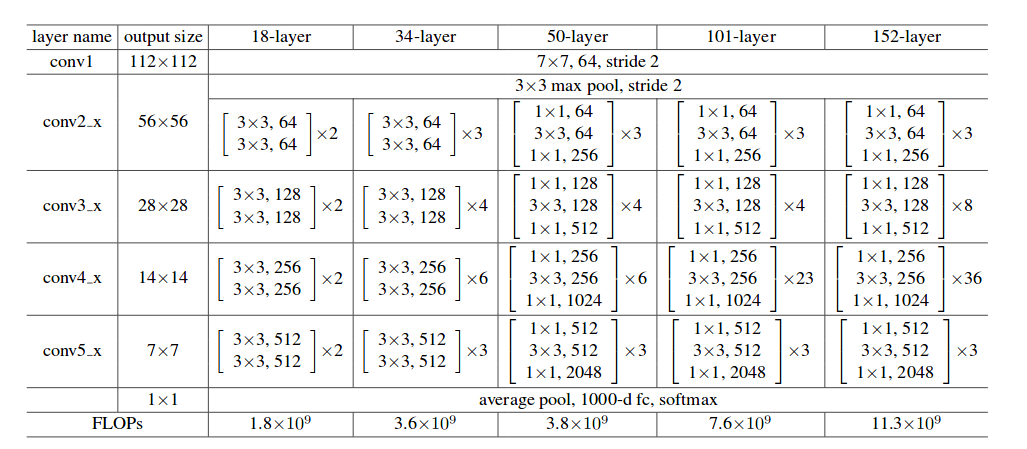

##### Pruned Resnet 50 (v1d 0.11) 

* Architecture is modified by
 1. setting stride at the 3x3 layer for a bottleneck block
 1. replacing the 7x7 conv layer with three 3x3 conv layers
 1. adding an avgpool layer 2x2 with stride 2 downsample feature map on the residual path to preserve more information
 1. changing last fc-layer 1000 nodes to 2 nodes
* More details in https://gluon-cv.mxnet.io/model_zoo/classification.html

### Copy with JPEG Compression
* This should be done before next phase
* Example how the image changes when adding more compression (quality = 30 in the left, quality = 1 in the right)
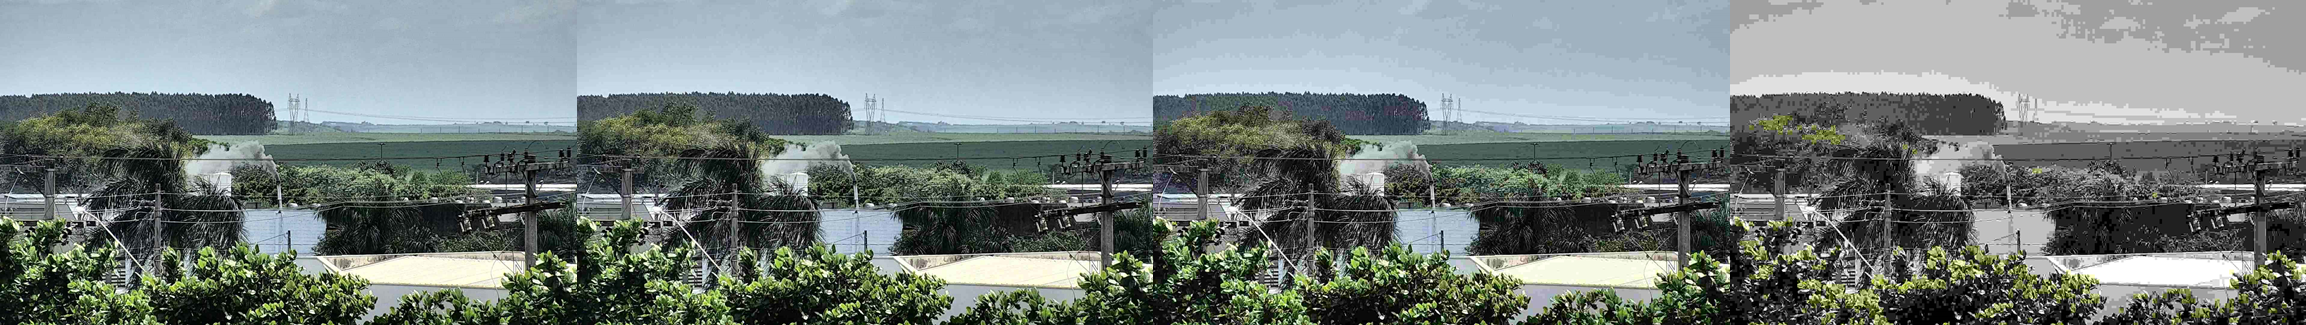

In [ ]:
from PIL import Image

In [ ]:
img_dir = 'C:/Temp/forestfire2/images/train'

In [ ]:
for root_dir, dirs, files in os.walk(img_dir):
    for fn in files:
        for comp in range(0, 60, 10):
            src = os.path.join(root_dir, fn);
            dst = os.path.join(root_dir, 'C' + str(comp) + '_' + fn.replace('.png', '.jpg'));
            print(src, '->', dst);
            im = Image.open(src);
            im.save(dst, quality=(comp+1));

### Preprocessing
* Images are from labelbox (8-9k)
* Separated to no_smoke and smoke folders (49% / 51%)
* Original image sizes are resized to 1280 x 720 (not required)
* Images are tranformed to record-file by using following scripts (`im2rec.py` can be found in mxnet github repo)

1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_train ./train/ --recursive --list --num-thread 10`
1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_valid ./valid/ --recursive --list --num-thread 10`
1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_test ./test/ --recursive --list --num-thread 10`
1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_train ./train/ --recursive \
--pass-through --pack-label --num-thread 10`
1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_valid ./valid/ --recursive \
--pass-through --pack-label --num-thread 10`
1. `python D:\dev\incubator-mxnet\tools\im2rec.py ./forestfire_test ./test/ --recursive \
--pass-through --pack-label --num-thread 10`


In [ ]:
%config IPCompleter.greedy=True

In [ ]:
import time
import os

import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

### Build the Model Architecture

1. The initial model can be downloaded with the following code

`ctx = mx.cpu(0)
net = get_model('ResNet50_v1d_0.11', pretrained=True)
net.hybridize()
x = np.zeros([1,3,1920,1080])
x = mx.nd.array(x)
output = net.forward(x)
gluon.nn.SymbolBlock.export(net, path='./forestfire-resnet50_v1d_011_mod')`

2. Last layer size should be changed from 1000 to 2
 * Open file `forestfire-resnet50_v1d_011_mod-symbol.json` to text editor
 * Then change 3 last nodes to 2
 * TODO: This should be done by code to be more easy to use

### Mixed Precision Training for Tensor Cores (Turing and Volta GPUs)
* More details in the following link
* https://nvlabs.github.io/iccv2019-mixed-precision-tutorial/files/dusan_stosic_intro_to_mixed_precision_training.pdf

In [ ]:
from mxnet.contrib import amp # for tensor cores

In [ ]:
amp.init() # for tensor cores

In [ ]:
batch_size = 24
num_workers = 12
img_w = 1280
img_h = 720
resize_h = 720
start_lr = 3e-2
lr_decay = 0.3
epochs = 20
lr_decay_count = 0
log_interval = 100
smooth_alpha = 0.3
max_angle = 0
random_crop = True
saturation = 0.5
brightness = 0.3
contrast = 0.1
pca_noise = 0
optimizer = 'adam';
optimizer_params = {'learning_rate': start_lr};
num_classes = 2
            
ctx = mx.gpu(0)

In [ ]:
net = gluon.nn.SymbolBlock.imports("forestfire-resnet50_v1d_011_v2_best-symbol.json", 
                                   ['data'], 
                                   "forestfire-resnet50_v1d_011_v2_best-0999.params", #TODO
                                   ctx=ctx)

### Network Size

* Original 101-layer architecture has 44,654,504 parameters
* Pruned version of 101-layer architecture has 30,790,514 parameters
* Pruned version of 50-layer architecture has 2,142,298 parameters

In [ ]:
net.summary(mx.nd.ones(shape=(24, 3, img_h, img_w), ctx=ctx))

In [ ]:
net.hybridize()
net.collect_params().initialize(mx.init.Uniform(), force_reinit=True, ctx = ctx)

In [ ]:
train_data = mx.io.ImageRecordIter(
    path_imgrec         = 'C:/Temp/forestfire2/images/forestfire_train.rec',
    path_imgidx         = 'C:/Temp/forestfire2/images/forestfire_train.idx',
    preprocess_threads  = 12,
    shuffle             = True,
    batch_size          = batch_size,
    
    max_rotate_angle    = max_angle,
    random_resized_crop = random_crop,
    resize              = resize_h,
    data_shape          = (3, img_h, img_w),
    rand_mirror         = True,
    saturation          = saturation,
    brightness          = brightness,
    contrast            = contrast
)

In [ ]:
val_data = mx.io.ImageRecordIter(
    path_imgrec         = 'C:/Temp/forestfire2/images/forestfire_valid.rec',
    path_imgidx         = 'C:/Temp/forestfire2/images/forestfire_valid.idx',
    preprocess_threads  = 12,
    shuffle             = False,
    batch_size          = batch_size,

    resize              = resize_h,
    data_shape          = (3, img_h, img_w),
)

In [ ]:
test_data = mx.io.ImageRecordIter(
    path_imgrec         = 'C:/Temp/forestfire2/images/forestfire_test.rec',
    path_imgidx         = 'C:/Temp/forestfire2/images/forestfire_test.idx',
    preprocess_threads  = 12,
    shuffle             = False,
    batch_size          = batch_size,

    resize              = resize_h,
    data_shape          = (3, img_h, img_w),
)

In [ ]:
# Trainer
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params, update_on_kvstore=False) # for tensor cores
amp.init_trainer(trainer) # for tensor cores
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

In [ ]:
# Batch Function
def batch_fn(batch, ctx):
    data = batch.data[0].as_in_context(ctx)
    label = batch.label[0].as_in_context(ctx)
    return data, label

In [ ]:
# Remap labels to probability distribution
def remap(y, K, ctx, smooth = 0):
    """ y = label, K = classes, ctx = CPU/GPU, smooth = label smoothing level """
    m = len(y)
    out = mx.nd.ones((m, K), ctx=ctx) * smooth
    for index in range(m):
        out[index][y[index]] = 1 - smooth
    return out

In [ ]:
# Training History Logs
train_history = TrainingHistory(['batch-acc', 'training-acc', 'loss', 'validation-acc'])

In [ ]:
# Validation Run
def test(ctx, val_data):
    correct = 0;
    total = 0;
    batches = 0;
    val_data.reset();
    for i, batch in enumerate(val_data):
        data, label = batch_fn(batch, ctx)
        with ag.record():
            output = net(data)
            predictions = nd.argmax(output, axis=1)       
        correct = mx.nd.sum(label == predictions);
        total += correct;
        batches += batch_size;
        acc_total = total / batches;
    return acc_total;

### Training

In [ ]:
best_val = 0.9
last_val = 0.

In [ ]:
smoothing_constant = .01

for epoch in range(epochs):
    batches = 0
    correct = 0
    total = 0
    train_data.reset()
    tic = time.time()
    btic = time.time()

    for i, batch in enumerate(train_data):
        data, label = batch_fn(batch, ctx)
        with ag.record():
            output = net(data);
            
            # Label smoothing
            y = remap(label, num_classes, ctx, smooth_alpha);

            loss = softmax_cross_entropy(output, y)
            predictions = nd.argmax(output, axis=1)
            with amp.scale_loss(loss, trainer) as scaled_loss: # for tensor cores
                ag.backward(scaled_loss)
        trainer.step(batch_size)
        
        batches += batch_size;
        correct = mx.nd.sum(label == predictions);
        total += correct;
        acc_batch = correct / batch_size;
        acc_total = total / batches;
        
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (epoch == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)
        
        
        if log_interval and not (i + 1) % log_interval:
            print('Epoch[%d] Batch [%d] Speed: %d samples/sec batch-accuracy=%.4f total-accuracy=%.4f loss=%.5f' % 
                  (epoch, 
                   i, 
                   batch_size*log_interval/(time.time()-btic), 
                   acc_batch.asnumpy(), 
                   acc_total.asnumpy(),
                   moving_loss
                  )
                )
            btic = time.time();

    acc_total_val = test(ctx, val_data)
    train_history.update([acc_batch.asnumpy(), acc_total.asnumpy(), moving_loss, acc_total_val.asnumpy()])

    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
    print('[Epoch %d] accuracy: train=%.5f test=%.5f'%(epoch, acc_total.asnumpy(), acc_total_val.asnumpy()))
    
    if (acc_total_val.asnumpy() > best_val):
        best_val = acc_total_val.asnumpy();
        print('+++++ Saving new best model...');
        net.export("forestfire-resnet50_v1d_011_v2_best", epoch=999);
        
    if (last_val > acc_total_val.asnumpy()):
        lr = trainer.learning_rate*lr_decay;
        print("* New Learning Rate:", lr);
        trainer.set_learning_rate(lr);
        
    last_val = acc_total_val.asnumpy();

In [ ]:
epoch

In [ ]:
net.export("forestfire-resnet50_v1d_011_v2_mod", epoch=epoch)

In [ ]:
train_history.plot()

### Testing the Parameters

In [ ]:
net = gluon.nn.SymbolBlock.imports("forestfire-resnet50_v1d_011_v2_best-symbol.json", 
                                   ['data'], 
                                   "forestfire-resnet50_v1d_011_v2_best-0999.params", #TODO
                                   ctx=ctx)

In [ ]:
net(mx.nd.ones(shape=(1, 3, img_h, img_w), ctx=ctx))

In [ ]:
converted_model = amp.convert_hybrid_block(net)

#### Validation Dataset

In [ ]:
cl = "smoke"
correct = 1 # 0 = no_smoke, 1 = smoke
i = 0.
total = 0.
correct_smoke = []
incorrect_smoke = []

In [ ]:
for root, dirs, files in os.walk("C:/Temp/forestfire2/images/valid/%s/" % cl):
    for f in files:
        filename = os.path.join(root, f)
        img = mx.img.imread(filename) 
        img = mx.img.resize_short(img, resize_h)
        img, (_, _, _, _) = mx.img.center_crop(img, (img_w,img_h)) # w, h
        img = img.transpose((2,0,1))
        result = converted_model(mx.nd.array(img.reshape(1,3,img_h,img_w), dtype=np.float32).as_in_context(ctx)).asnumpy().argmax(axis=1)[0]
        if (correct == result):
            correct_smoke.append(filename);
            total += 1;
        else:
            incorrect_smoke.append(filename);
        i += 1;
    print("Class %s accuracy: %.5f" % (cl, (total/i)))

In [ ]:
cl = "no_smoke"
correct = 0 # 0 = no_smoke, 1 = smoke
i = 0.
total = 0.
correct_no_smoke = []
incorrect_no_smoke = []

In [ ]:
for root, dirs, files in os.walk("C:/Temp/forestfire2/images/valid/%s/" % cl):
    for f in files:
        filename = os.path.join(root, f)
        img = mx.img.imread(filename) 
        img = mx.img.resize_short(img, resize_h)
        img, (_, _, _, _) = mx.img.center_crop(img, (img_w,img_h)) # w, h
        img = img.transpose((2,0,1))
        result = converted_model(mx.nd.array(img.reshape(1,3,img_h,img_w), dtype=np.float32).as_in_context(ctx)).asnumpy().argmax(axis=1)[0]
        if (correct == result):
            correct_no_smoke.append(filename);
            total += 1;
        else:
            incorrect_no_smoke.append(filename);
        i += 1;
    print("Class %s accuracy: %.5f" % (cl, (total/i)))

In [ ]:
total = (
    len(correct_smoke)+
    len(correct_no_smoke)+
    len(incorrect_no_smoke)+
    len(incorrect_smoke)
)

In [ ]:
correct = (
    len(correct_no_smoke)+
    len(correct_smoke)
)

In [ ]:
print("TP:", len(correct_smoke))
print("TN:", len(correct_no_smoke))
print("FP:", len(incorrect_no_smoke))
print("FN:", len(incorrect_smoke))

In [ ]:
correct/total

In [ ]:
#Precision
precision = len(correct_smoke)/(len(correct_smoke)+len(incorrect_no_smoke))
precision

In [ ]:
#Recall
recall = len(correct_smoke)/(len(correct_smoke)+len(incorrect_smoke))
recall

#### Test Dataset

In [ ]:
cl = "smoke"
correct = 1 # 0 = no_smoke, 1 = smoke
i = 0.
total = 0.
correct_smoke = []
incorrect_smoke = []

In [ ]:
for root, dirs, files in os.walk("C:/Temp/forestfire2/images/test/%s/" % cl):
    for f in files:
        filename = os.path.join(root, f)
        img = mx.img.imread(filename) 
        img = mx.img.resize_short(img, resize_h)
        img, (_, _, _, _) = mx.img.center_crop(img, (img_w,img_h)) # w, h
        img = img.transpose((2,0,1))
        result = converted_model(mx.nd.array(img.reshape(1,3,img_h,img_w), dtype=np.float32).as_in_context(ctx)).asnumpy().argmax(axis=1)[0]
        if (correct == result):
            correct_smoke.append(filename);
            total += 1;
        else:
            incorrect_smoke.append(filename);
        i += 1;
    print("Class %s accuracy: %.5f" % (cl, (total/i)))

In [ ]:
cl = "no_smoke"
correct = 0 # 0 = no_smoke, 1 = smoke
i = 0.
total = 0.
correct_no_smoke = []
incorrect_no_smoke = []

In [ ]:
for root, dirs, files in os.walk("C:/Temp/forestfire2/images/test/%s/" % cl):
    for f in files:
        filename = os.path.join(root, f)
        img = mx.img.imread(filename) 
        img = mx.img.resize_short(img, resize_h)
        img, (_, _, _, _) = mx.img.center_crop(img, (img_w,img_h)) # w, h
        img = img.transpose((2,0,1))
        result = converted_model(mx.nd.array(img.reshape(1,3,img_h,img_w), dtype=np.float32).as_in_context(ctx)).asnumpy().argmax(axis=1)[0]
        if (correct == result):
            correct_no_smoke.append(filename);
            total += 1;
        else:
            incorrect_no_smoke.append(filename);
        i += 1;
    print("Class %s accuracy: %.5f" % (cl, (total/i)))

In [ ]:
total = (
    len(correct_smoke)+
    len(correct_no_smoke)+
    len(incorrect_no_smoke)+
    len(incorrect_smoke)
)

In [ ]:
correct = (
    len(correct_no_smoke)+
    len(correct_smoke)
)

In [ ]:
print("TP:", len(correct_smoke))
print("TN:", len(correct_no_smoke))
print("FP:", len(incorrect_no_smoke))
print("FN:", len(incorrect_smoke))

In [ ]:
correct/total

In [ ]:
#Precision
precision = len(correct_smoke)/(len(correct_smoke)+len(incorrect_no_smoke))
precision

In [ ]:
#Recall
recall = len(correct_smoke)/(len(correct_smoke)+len(incorrect_smoke))
recall